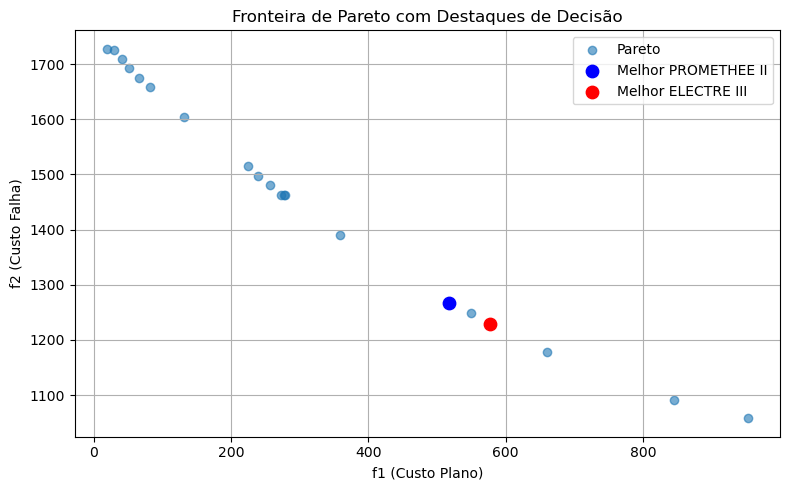

<Figure size 800x500 with 0 Axes>

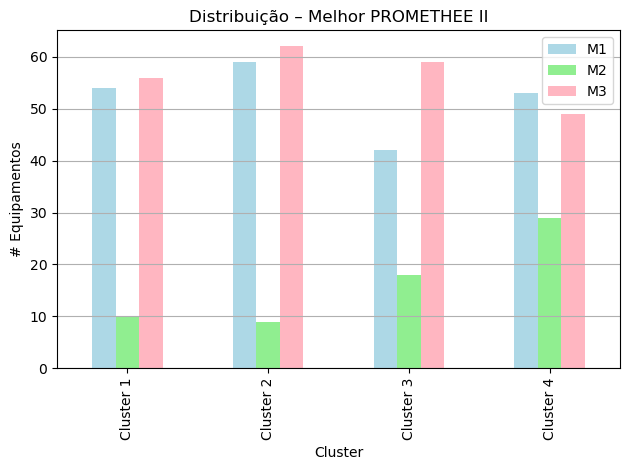

<Figure size 800x500 with 0 Axes>

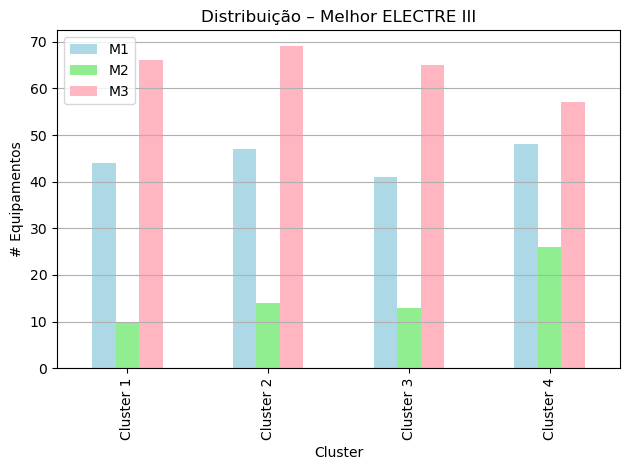

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------- configurações -----------------------------
CORES_PLANOS = ["lightblue", "lightgreen", "lightpink"]
NOMES_CLUSTERS = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

# caminhos dos arquivos
CSV_SOLUCOES = "resultados_pareto_epsilon_rest_penalidade_2025-06-23_01-34-10.csv"
PATH_EQUIP = "arquivos_tc/EquipDB.csv"
PATH_CLUSTER = "arquivos_tc/ClusterDB.csv"
PATH_PLANOS = "arquivos_tc/MPDB.csv"

# ----------------------------- carregamento -----------------------------
df_sol = pd.read_csv(CSV_SOLUCOES)
equip_db = pd.read_csv(PATH_EQUIP, header=None)
cluster_db = pd.read_csv(PATH_CLUSTER, header=None)
mp_db = pd.read_csv(PATH_PLANOS, header=None)

# número de equipamentos e planos
N = equip_db.shape[0]
J = 3

# função de distribuição acumulada de Weibull (cdf)
def weibull_cdf(t, eta, beta):
    return 1 - np.exp(-(t / eta) ** beta)

delta_t = 5
# custo de falha por equipamento
d_i = equip_db.iloc[:, 3].values

# inicializa e calcula matrizes de probabilidade e custo esperado
matriz_prob = np.zeros((N, J))
matriz_custo_esperado = np.zeros((N, J))
for i in range(N):
    t0 = equip_db.iloc[i, 1]
    cid = int(equip_db.iloc[i, 2])
    eta = cluster_db.loc[cluster_db[0] == cid, 1].values[0]
    beta = cluster_db.loc[cluster_db[0] == cid, 2].values[0]
    for j in range(J):
        k = mp_db.iloc[j, 1]
        numer = weibull_cdf(t0 + k * delta_t, eta, beta) - weibull_cdf(t0, eta, beta)
        denom = 1 - weibull_cdf(t0, eta, beta)
        p = numer / denom
        matriz_prob[i, j] = p
        matriz_custo_esperado[i, j] = p * d_i[i]

# custos de aplicação dos planos (f1)
c_j = mp_db.iloc[:, 2].values

# calcula f1 e f2 para cada solução carregada
f1_list = []
f2_list = []
for _, row in df_sol.iterrows():
    planos = row.values.astype(int)
    # custo total de manutenção
    f1 = np.sum(c_j[planos - 1])
    # custo esperado de falha total
    f2 = sum(matriz_custo_esperado[i, planos[i] - 1] for i in range(N))
    f1_list.append(f1)
    f2_list.append(f2)

df_sol['f1'] = f1_list
df_sol['f2'] = f2_list

# filtra não-dominadas e normaliza f1 e f2
nd = df_sol.drop_duplicates(['f1', 'f2']).reset_index(drop=True)
min_f1, max_f1 = nd['f1'].min(), nd['f1'].max()
min_f2, max_f2 = nd['f2'].min(), nd['f2'].max()
nd['f1_norm'] = (nd['f1'] - min_f1) / (max_f1 - min_f1)
nd['f2_norm'] = (nd['f2'] - min_f2) / (max_f2 - min_f2)

# limita a 20 soluções
if len(nd) > 20:
    df = nd.sample(20, random_state=203).reset_index(drop=True)
else:
    df = nd.copy()

# matriz de decisão normalizada e pesos iguais
matriz = df[['f1_norm', 'f2_norm']].values
pesos = np.array([0.5, 0.5])

# ----------------------------- PROMETHEE II -----------------------------
# calcula fluxo líquido (net flow)
def promethee_ii(matriz, pesos):
    n = matriz.shape[0]
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            P[i, j] = np.dot(pesos, np.maximum(0, matriz[j] - matriz[i]))
    phi_p = P.sum(axis=1) / (n - 1)
    phi_m = P.sum(axis=0) / (n - 1)
    return phi_p - phi_m

# aplica PROMETHEE II e identifica melhor solução
df['Fluxo_PROMETHEE_II'] = promethee_ii(matriz, pesos)
best_pi = df['Fluxo_PROMETHEE_II'].idxmax()

# ----------------------------- ELECTRE III -----------------------------
# implementa outranking com limiares p (preferência), q (indiferença) e v (veto)
def electre_iii(matriz, pesos, p=0.1, q=0.05, v=0.2):
    n, m = matriz.shape
    C = np.zeros((n, n))
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            c_sum = 0.0
            d_max = 0.0
            for k in range(m):
                diff = matriz[j, k] - matriz[i, k]
                # grau de concordância
                if diff >= p:
                    c_k = 1.0
                elif diff <= q:
                    c_k = 0.0
                else:
                    c_k = (diff - q) / (p - q)
                c_sum += pesos[k] * c_k
                # discordância com veto
                if diff < 0:
                    d_k = max(0, abs(diff) - v) / (1 - v)
                else:
                    d_k = 0.0
                d_max = max(d_max, d_k)
            C[i, j] = c_sum
            D[i, j] = d_max
    S = C >= D
    phi_p = S.sum(axis=1)
    phi_m = S.sum(axis=0)
    return phi_p - phi_m

# aplica ELECTRE III e identifica melhor solução
df['Fluxo_ELECTRE_III'] = electre_iii(matriz, pesos)
best_ei = df['Fluxo_ELECTRE_III'].idxmax()

# ----------------------------- PLOT: Fronteira com destaques -----------------------------
plt.figure(figsize=(8, 5))
plt.scatter(df['f1'], df['f2'], alpha=0.6, label='Pareto')
plt.scatter(df.loc[best_pi, 'f1'], df.loc[best_pi, 'f2'], color='blue', label='Melhor PROMETHEE II', s=80)
plt.scatter(df.loc[best_ei, 'f1'], df.loc[best_ei, 'f2'], color='red', label='Melhor ELECTRE III', s=80)
plt.xlabel('f1 (Custo Plano)')
plt.ylabel('f2 (Custo Falha)')
plt.title('Fronteira de Pareto com Destaques de Decisão')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------- Bar: Distribuição – PROMETHEE II -----------------------------
sol_pi = df.loc[best_pi, df.columns.str.startswith('x')].astype(int).values
plot_pi = pd.DataFrame({'Cluster': equip_db.iloc[:, 2].astype(int).values, 'Plano': sol_pi})
freq_pi = pd.crosstab(plot_pi['Cluster'], plot_pi['Plano'])
freq_pi.index = NOMES_CLUSTERS
freq_pi.columns = [f'M{c}' for c in freq_pi.columns]
plt.figure(figsize=(8, 5))
freq_pi.plot(kind='bar', color=CORES_PLANOS)
plt.title('Distribuição – Melhor PROMETHEE II')
plt.xlabel('Cluster')
plt.ylabel('# Equipamentos')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ----------------------------- Bar: Distribuição – ELECTRE III -----------------------------
sol_ei = df.loc[best_ei, df.columns.str.startswith('x')].astype(int).values
plot_ei = pd.DataFrame({'Cluster': equip_db.iloc[:, 2].astype(int).values, 'Plano': sol_ei})
freq_ei = pd.crosstab(plot_ei['Cluster'], plot_ei['Plano'])
freq_ei.index = NOMES_CLUSTERS
freq_ei.columns = [f'M{c}' for c in freq_ei.columns]
plt.figure(figsize=(8, 5))
freq_ei.plot(kind='bar', color=CORES_PLANOS)
plt.title('Distribuição – Melhor ELECTRE III')
plt.xlabel('Cluster')
plt.ylabel('# Equipamentos')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
